In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 위성 이미지 바운딩박스 시각화
- 바운딩 박스를 이미지에 도식하기 위한 코드

In [ ]:
# Copyright 2017 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

## 개요

이 코드는 주어진 데이터셋(이미지, geojson)을 활용하여 원본 이미지에 바운딩 박스를 시각화하는 것을 목적으로 합니다.

- 원본자료: Baseline utils 폴더의 visualization_utils.py 모듈입니다.

## 라이브러리 임포트

In [ ]:
import math
import os
import json
import numpy as np
import cv2
import PIL.Image as Image
import PIL.ImageColor as ImageColor
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
import matplotlib.pyplot as plt

## load_geojson 정의

In [ ]:
IMAGE_PATH = '/content/drive/Shareddrives/해커톤/1_data/위성영상_객체판독/Training/train_objects_data/'
JSON_PATH = '/content/drive/Shareddrives/해커톤/1_data/위성영상_객체판독/Training/train_objects_labeling'

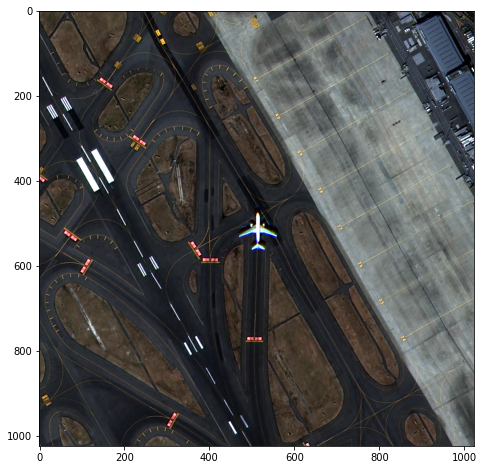

In [ ]:
json_image_path = os.path.join(IMAGE_PATH, 'OBJ00013_PS3_K3_NIA0078.png')
json_image = cv2.imread(os.path.join(json_image_path))
json_image = cv2.cvtColor(json_image, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(json_image)
plt.show()

### geojson 파일에서 원하는 값 불러오기 위한 load_geojson 함수를 정의

#### 원하는 출력값
- features --> properties 카테고리
- 이미지 이름(image_id): image_ids, 바운딩 박스 좌표(bounds_imcoords): obj_coords
- 클래스 라벨(type_id): class_indices, 클래스 이름(type_name): class_names



In [ ]:
def load_geojson(filename):
    """ Gets label data from a geojson label file

    :param (str) filename: file path to a geojson label file
    :return: (numpy.ndarray, numpy.ndarray ,numpy.ndarray) coords, chips, and classes corresponding to
            the coordinates, image names, and class codes for each ground truth.
    """

    with open(filename) as f:
        data = json.load(f)
        
    ## 각 출력값의 크기에 맞는 0으로 구성된 array를 생성해줍니다.
    
        obj_coords = np.zeros(len(data['features']), dtype='object')
        image_ids = np.zeros(len(data['features']), dtype='object')
        class_indices = np.zeros((len(data['features'])), dtype=int)
        class_names = np.zeros((len(data['features'])), dtype='object')
    
    ## geojson에 있는 실제값들을 위에서 생성한 변수들에 할당해줍니다.
    
    for idx in range(len(data['features'])):
        properties = data['features'][idx]['properties']
        image_ids[idx] = properties['image_id']
        obj_coords[idx] = np.array([float(num) for num in properties['object_imcoords'].split(",")])
        class_indices[idx] = properties['type_id']
        class_names[idx] = properties['type_name']

    return image_ids, obj_coords, class_indices, class_names


## cvt_coords_to_rboxes 함수 정의

geojson 파일은 ground_truth의 바운딩박스 좌표를 각 모서리의 x, y 값 총 8개의 좌표 `[x1, y1, x2, y2, x3, y3, x4, y4]`로 `N개`를 가지고 있습니다.

N개의 바운딩 박스 좌표 (N, 8)를 N개의 `[center_y(cy), center_x(cx), height, width, theta]` 리스트를 가지는 `rboxes로 변환`해주기 위한 헬퍼 함수 **cvt_coords_to_rboxes**를 정의합니다.

In [ ]:
def cvt_coords_to_rboxes(coords):
    """ Processes a coordinate array from a geojson into (cy, cx, height, width, theta) format

    :param (numpy.ndarray) coords: an array of shape (N, 8) with 4 corner points of boxes
    :return: (numpy.ndarray) an array of shape (N, 5) with coordinates in proper format
    """

    rboxes = []
    for coord in coords:
        pts = np.reshape(coord, (-1, 2)).astype(dtype=np.float32)
        (cx, cy), (width, height), theta = cv2.minAreaRect(pts)

        if width < height:
            width, height = height, width
            theta += 90.0
        rboxes.append([cy, cx, height, width, math.radians(theta)])

    return np.array(rboxes)

## draw_bounding_rbox_on_image
바운딩 박스를 이미지에 그리기 위한 함수인 draw_bounding_rbox_on_image 를 정의합니다.

이 함수는 PIL.Image object 를 이미지 타입으로 받습니다.

In [ ]:
def draw_bounding_rbox_on_image(image,
                                cy,
                                cx,
                                h,
                                w,
                                ang,
                                color='blue',
                                thickness=4,
                                display_str_list=(),
                                use_normalized_coordinates=True):
    """Adds a bounding box to an image.

    Each string in display_str_list is displayed on a separate line above the
    bounding box in black text on a rectangle filled with the input 'color'.

    Args:
      image: a PIL.Image object.
      cy: center y of rotated bounding box. in normalized coordinates (same below).
      cx: center x of rotated bounding box.
      h: height of rotated bounding box.
      w: width of rotated bounding box.
      ang: angle of rotated bounding box.
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
      display_str_list: list of strings to display in box
                        (each to be shown on its own line).
      use_normalized_coordinates: If True (default), treat coordinates
        cy, cx, h, w as relative to the image.  Otherwise treat coordinates as absolute.
    """
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    if use_normalized_coordinates:
        cy, cx, h, w = cy * im_height, cx * im_width, h * im_height, w * im_width

    points = cv2.boxPoints(((cx, cy), (w, h), math.degrees(ang))).tolist()
    points.append(points[0])
    points = [(x, y) for x, y in points]
    draw.line(points, width=thickness, fill=color)
    
    try:
        font = ImageFont.truetype('arial.ttf', 24)
    except IOError:
        font = ImageFont.load_default()


    text_bottom = cy
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(cx, text_bottom - text_height - 2 * margin), (cx + text_width, text_bottom)],
                       fill=color)
        draw.text((cx + margin, text_bottom - text_height - margin), display_str,
                  fill='black',
                  font=font)
        text_bottom -= text_height - 2 * margin

In [ ]:
# 이미지를 numpy array 타입으로 받기위한 헬퍼 함수인 draw_bounding_rbox_on_image_array 함수 정의
# 반환하는 값은 rbox가 적용된 numpy array 타입의 image
def draw_bounding_rbox_on_image_array(image,
                                      cy,
                                      cx,
                                      h,
                                      w,
                                      ang,
                                      color='red',
                                      thickness=4,
                                      display_str_list=(),
                                      use_normalized_coordinates=True):
    """Adds a bounding box to an image (numpy array).

    Args:
      image: a numpy array with shape [height, width, 3].
      cy: center y of rotated bounding box. in normalized coordinates (same below).
      cx: center x of rotated bounding box.
      h: height of rotated bounding box.
      w: width of rotated bounding box.
      ang: angle of rotated bounding box.
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
      display_str_list: list of strings to display in box(each to be shown on its own line).
      use_normalized_coordinates: If True (default), treat coordinates
        cy, cx, h, w as relative to the image.  Otherwise treat coordinates as absolute.
    """
    image_pil = Image.fromarray(np.uint8(image)).convert('RGB')
    draw_bounding_rbox_on_image(image_pil, cy, cx, h, w, ang, color,
                                thickness, display_str_list,
                                use_normalized_coordinates)
    np.copyto(image, np.array(image_pil))
    
    return image

## draw_bounding_rboxes_on_image를 정의
- 하나의 이미지에 다수의 바운딩 박스를 적용하기 위한 함수
- `draw_bounding_rboxes_on_image` 함수는 `draw_bounding_rbox_on_image`를 베이스로 여러개의 바운딩 박스를 그리게 해주는 함수입니다.

In [ ]:
def draw_bounding_rboxes_on_image(image,
                                  rboxes,
                                  color='red',
                                  thickness=4,
                                  display_str_list_list=()):
    """Draws bounding boxes on image.

    Args:
      image: a PIL.Image object.
      rboxes: a 2 dimensional numpy array of [N, 5]: (cy, cx, h, w, ang).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
      display_str_list_list: list of list of strings.
                             a list of strings for each bounding box.
                             The reason to pass a list of strings for a
                             bounding box is that it might contain
                             multiple labels.

    Raises:
      ValueError: if boxes is not a [N, 5] array
    """
    boxes_shape = rboxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 5:
        raise ValueError('Input must be of size [N, 5]')
    for i in range(boxes_shape[0]):
        display_str_list = ()
        if display_str_list_list:
            display_str_list = display_str_list_list[i]
        draw_bounding_rbox_on_image(image, rboxes[i, 0], rboxes[i, 1], rboxes[i, 2], rboxes[i, 3], rboxes[i, 4],
                                    color, thickness, display_str_list)

## draw_bounding_rboxes_on_image_array 함수를 정의

- draw_bounding_rboxes_on_image에서 이미지를 numpy array 타입으로 받기위한 헬퍼 함수
- 반환하는 값은 rboxes가 적용된 numpy array 타입의 image 입니다.

In [ ]:
def draw_bounding_rboxes_on_image_array(image,
                                        rboxes,
                                        color='red',
                                        thickness=4,
                                        display_str_list_list=()):
    """Draws bounding boxes on image (numpy array).

    Args:
      image: a numpy array object.
      rboxes: a 2 dimensional numpy array of [N, 5]: (cy, cx, h, w, ang).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
      display_str_list_list: list of list of strings.
                             a list of strings for each bounding box.
                             The reason to pass a list of strings for a
                             bounding box is that it might contain
                             multiple labels.

    Raises:
      ValueError: if boxes is not a [N, 4] array
    """
    image_pil = Image.fromarray(image)
    draw_bounding_rboxes_on_image(image_pil, rboxes, color, thickness, display_str_list_list)
    np.copyto(image, np.array(image_pil))
    
    return image

함수 정의 끝. 정의된 함수를 사용하여 훈련 데이터셋 파일을 도식화 해보겠습니다.

geojson 파일의 경로를 설정 후, load_geojson 함수를 이용하여 아래의 값들을 할당 받음

- 이미지 이름 : image_ids
- 바운딩박스의 좌표 : obj_coords
- 클래스 라벨 : class_indices
- 클래스 이름 : class_names

In [ ]:
geojson_path = os.path.join(JSON_PATH, 'OBJ00013_PS3_K3_NIA0078.json')
image_ids, obj_coords, class_indices, class_names = load_geojson(geojson_path)

In [ ]:
# 훈련 데이터셋의 이미지 경로를 설정합니다.
image_path = os.path.join(IMAGE_PATH, 'OBJ00013_PS3_K3_NIA0078.png')
image = cv2.imread(os.path.join(image_path))

In [ ]:
# 각 모서리값으로 설정되어 있는 (N, 8) 크기의 바운딩 박스의 좌표를 cvt_coords_to_rboxes 함수를 사용하여
# N개의 cy, cx, height, width, theta 의 값을 가지는 값으로 변경해줍니다.
obj_coords = cvt_coords_to_rboxes(obj_coords)

## rbox 도식 전 참고사항
기존 0~1 사이의 값으로 정규화하는 코드에서 이미지의 사이즈로 나눠서 정규화를 해야되는데 3000으로 나눠서 cy, cx, height, width값에서 차이가 발생

In [ ]:
"""
cy, cx, height, width 값을 0~1 사이의 값으로 정규화 시켜줍니다.
이는 draw_bounding_rbox_on_image 함수의 파라미터인
use_normalized_coordinates 값이 True 일 경우 정규화 시켜줍니다.
"""
# obj_coords[:, :4] = obj_coords[:, :4] / 3000
obj_coords[:, :4] = obj_coords[:, :4] / 1024

## draw_bounding_rboxes_on_image_array 함수 추가사항
draw_bounding_rboxes_on_image_array 함수를 사용할 때 객체의 개수에 따라 rbox를 도식하기 위해 기존 코드와 같이 obj_coords[:7]과 같이 사용하는 것이 아니라 len(obj_coords)를 사용하는 것이 좋아보인다!

In [ ]:
"""
이미지의 색상을 변경하고 **draw_bounding_rboxes_on_image_array 함수를 이용하여
numpy array 타입을 가지는 image를 반환 받습니다.
0.png 파일의 바운딩 박스의 개수는 7개이므로 7개의 바운딩 박스 값으로 obj_coords 값을 슬라이싱 하겠습니다.
"""
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = draw_bounding_rboxes_on_image_array(image, obj_coords[:7])
image = draw_bounding_rboxes_on_image_array(image, obj_coords[:len(obj_coords)])

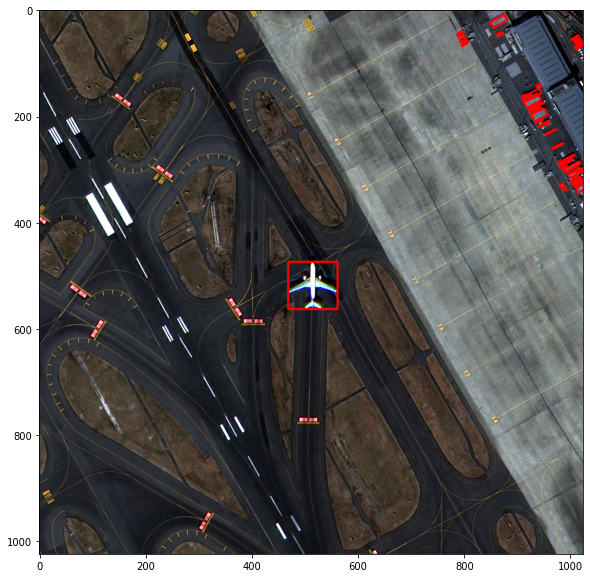

In [ ]:
# 이미지 도식화
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)
plt.show()

## 다른 이미지로 시도

In [ ]:
geojson_path = os.path.join(JSON_PATH, 'OBJ01347_PS3_K3_NIA0092.json')
image_ids, obj_coords, class_indices, class_names = load_geojson(geojson_path)

In [ ]:
# 훈련 데이터셋의 이미지 경로를 설정합니다.
image_path = os.path.join(IMAGE_PATH, 'OBJ01347_PS3_K3_NIA0092.png')
image = cv2.imread(os.path.join(image_path))

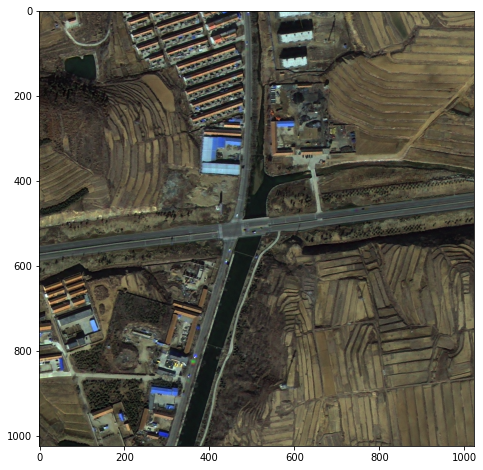

In [ ]:
json_image_path = os.path.join(IMAGE_PATH, 'OBJ01347_PS3_K3_NIA0092.png')
json_image = cv2.imread(os.path.join(json_image_path))
json_image = cv2.cvtColor(json_image, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(json_image)
plt.show()

In [ ]:
# 각 모서리값으로 설정되어 있는 (N, 8) 크기의 바운딩 박스의 좌표를 cvt_coords_to_rboxes 함수를 사용하여
# N개의 cy, cx, height, width, theta 의 값을 가지는 값으로 변경해줍니다.
obj_coords = cvt_coords_to_rboxes(obj_coords)

In [ ]:
"""
cy, cx, height, width 값을 0~1 사이의 값으로 정규화 시켜줍니다.
이는 draw_bounding_rbox_on_image 함수의 파라미터인
use_normalized_coordinates 값이 True 일 경우 정규화 시켜줍니다.
"""
obj_coords[:, :4] = obj_coords[:, :4] / 1024

In [ ]:
"""
이미지의 색상을 변경하고 **draw_bounding_rboxes_on_image_array 함수를 이용하여
numpy array 타입을 가지는 image를 반환 받습니다.
0.png 파일의 바운딩 박스의 개수는 7개이므로 7개의 바운딩 박스 값으로 obj_coords 값을 슬라이싱 하겠습니다.
"""
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = draw_bounding_rboxes_on_image_array(image, obj_coords[:len(obj_coords)])

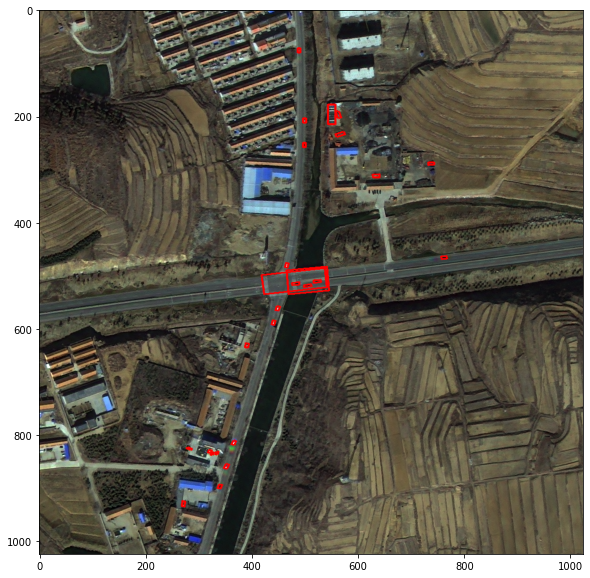

In [ ]:
# 이미지 도식화
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)
plt.show()

## Furthermore

- 앞 서 정의한 함수 draw_bounding_rbox_on_image에는 display_str_list 라는 로직이 추가적으로 포함되어 있습니다. 이 로직이 어떠한 로직인지 이해를 해보시면 좋을 것 같습니다.
- 이미지를 불러오는 것을 수동으로 정의하였고, 바운딩 박스 또한 수동으로 불러왔습니다.
- 이를 자동화하는 로직이 Baseline utils 폴더에 존재하는 visualization_utils.py 모듈에 있습니다. 이에 대해 시도해보시면 좋을 것 같습니다.